In [0]:
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [0]:
#note that here text is the whole text as a single string because we arent splitting

def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    name = f.namelist()[0]
    data = tf.compat.as_str(f.read(name))
  return data
  
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


In [0]:
#creating a small validation set

valid_size = 1000
valid_text = text[:valid_size]
train_text = text[valid_size:]
train_size = len(train_text)

print("Prinitng the beginning of training text->")
print(train_text[:64])
print()

print("Printing the beginning of validaiton test->")
print(valid_text[:64])
print()

Prinitng the beginning of training text->
ons anarchists advocate social relations based upon voluntary as

Printing the beginning of validaiton test->
 anarchism originated as a term of abuse first used against earl



In [0]:
vocabulary_size = len(string.ascii_lowercase) + 1
first_letter = ord(string.ascii_lowercase[0])


def char2id(char):
  
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  else:
    print("Unexpected character {}".format(char))
    return 0
  
def id2char(dictid):
  if dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '
  
print("vocabulary_size is {}".format(vocabulary_size))

print("a-> {}, z-> {}".format(char2id('a'), char2id('z')))
print("1-> {}, 26-> {}".format(id2char(1), id2char(26)))

vocabulary_size is 27
a-> 1, z-> 26
1-> a, 26-> z


In [0]:
batch_size = 64
num_unrollings = 10

class BatchGenerator(object):
  
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    
    #maybe how many batches will be formed from the text
    segment = self._text_size // self._batch_size
    
    #this may show the starting points of various batches
    #this step moves from one batcg to another
    self._cursor = [offset * segment for offset in range(self._batch_size)]
    
    self._last_batch = self._next_batch()
    
    
  def _next_batch(self):
    """Generate a batch from current cursor position in the data"""

    #maybe we are using np.zeros so that we will only need to change the 
    #ids to 1 only for the true character.
    #if we had used np.ndarray we would have required to explicity
    #set other 26 ids to 0

    batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)

    for b in range(self._batch_size):
      #setting corresponding ids to 1

      batch[b,char2id(self._text[self._cursor[b]])] = 1.0
      #to move to next character in the batch
      #reaminder by ._text_size as we will reiterate over data multiple times
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size

    return batch
    
    
  def next(self):
    """Generates next array of batches from the data. The array consists of the last
    batch of the previous array, followed by num_unrollings new ones"""

    batches = [self._last_batch]

    #appending _num_unrollings more batches
    for _ in range(self._num_unrollings):
      batches.append(self._next_batch())       
    self._last_batch = batches[-1]

    return batches
      
      
def characters(probabilities):
  """Gives characters form probabilities.
  Turn a 1-hot encoding or a probability distributon"""
  #iterating over the probabilities matrix
  return [id2char(c) for c in np.argmax(probabilities,1)]
  
  
def batches2string(batches):
  """Converts a sequence of batches into their most likely
  string representation"""
    
  s = ['']*batches[0].shape[0]
    
  for b in batches:
    #seperator.join(iterable) will join each item from iterable with other 
    #by a seperator. example ','.join(['a','b',c]) will give a,b,c
    s = [''.join(x) for x in zip(s, characters(b))]
  return s
  
  

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)



  
        
        

In [0]:
#printing the batches
#note that lists are iterables hence the next funtion works
print("From training set")
print(batches2string(train_batches.next()))
print()
print(batches2string(train_batches.next()))
print()

print("From validation set")
print(batches2string(valid_batches.next()))
print()
print(batches2string(valid_batches.next()))


From training set
['ons anarchi', 'when milita', 'lleria arch', ' abbeys and', 'married urr', 'hel and ric', 'y and litur', 'ay opened f', 'tion from t', 'migration t', 'new york ot', 'he boeing s', 'e listed wi', 'eber has pr', 'o be made t', 'yer who rec', 'ore signifi', 'a fierce cr', ' two six ei', 'aristotle s', 'ity can be ', ' and intrac', 'tion of the', 'dy to pass ', 'f certain d', 'at it will ', 'e convince ', 'ent told hi', 'ampaign and', 'rver side s', 'ious texts ', 'o capitaliz', 'a duplicate', 'gh ann es d', 'ine january', 'ross zero t', 'cal theorie', 'ast instanc', ' dimensiona', 'most holy m', 't s support', 'u is still ', 'e oscillati', 'o eight sub', 'of italy la', 's the tower', 'klahoma pre', 'erprise lin', 'ws becomes ', 'et in a naz', 'the fabian ', 'etchy to re', ' sharman ne', 'ised empero', 'ting in pol', 'd neo latin', 'th risky ri', 'encyclopedi', 'fense the a', 'duating fro', 'treet grid ', 'ations more', 'appeal of d', 'si have mad']

['ists advoca', 'ary

In [0]:
a = np.array(
    [[4,7,9,10],
     [3,1,2,5],
     [8,2,1,4],
     [0,9,11,3]])

a<5

array([[ True, False, False, False],
       [ True,  True,  True, False],
       [False,  True,  True,  True],
       [ True, False, False,  True]])

In [0]:
def logprob(predictions, labels):
  """Log-probabilities of the true labels in a predicted batch"""
  #the values lower than 1e-10 are changed to 1e-10
  #look at code block above to see how python creates flags easily
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels,-np.log(predictions))) / labels.shape[0]


#the below is similar to roulette method of genetic algorithm. Basically if we have
#a distribution like [0.1,0.3,0.2,0.4] then the function will return classes
#with probabilities 0.1,0.2,0.3,0.4 respectively rather than always returning
#the class with highest probability
def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities"""
  
  #the needle of roulette
  r = random.uniform(0,1)
  s = 0
  
  #right now not understanding what all this really is
  for i in range(len(distribution)):
    s += distribution[i]
    if s>= r:
      return i
  return len(distribution) - 1
  

def sample(prediction):
  """Turn a column prediction into 1-hot encoded sample"""
  p = np.zeros(shape=[1,vocabulary_size], dtype = np.float)
  p[0, sample_distribution(prediction[0])] =1.0
  return p


def random_distribution():
  """Generate a random column of probabilities"""
  b = np.random.uniform(0.0,1.0, size = [1,vocabulary_size])
  
  #didnt really get functions in the last line
  #perhaps returns the normalized vector
  return b/np.sum(b,1)[:,None]
    

##Run to see truncated_normal function

In [0]:
n = 500000
A = tf.truncated_normal([n,1], -0.1, 0.1)
B = tf.random_normal([n,1], -0.1, 0.2)

with tf.Session() as sess:
    a, b = sess.run([A, B])


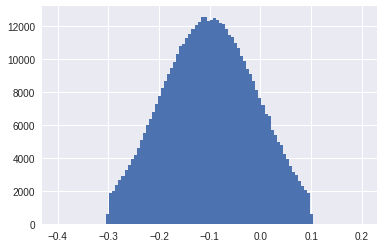

In [0]:
plt.hist(a, 100, (-0.4, 0.2));

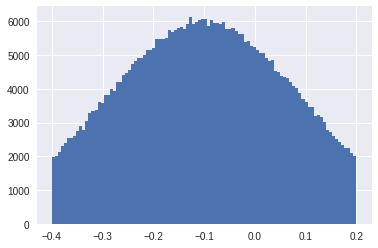

In [0]:
plt.hist(b, 100, (-0.4, 0.2));

##Model continued





In [0]:
#simple LSTM model

num_nodes = 64

graph = tf.Graph()
with graph.as_default():
  
  #Parameters:
  #need to understand why will we have a mean of -0.1 and std of 0.1
  
  # Input gate: input, previous output, and bias
  #seems like we are having something like XM+b
  ix = tf.Variable(tf.truncated_normal(shape=[vocabulary_size, num_nodes],
                                      mean = -0.1, stddev = 0.1))
  im = tf.Variable(tf.truncated_normal(shape=[num_nodes, num_nodes],
                                      mean = -0.1, stddev = 0.1))
  ib = tf.Variable(tf.zeros(shape=[1,num_nodes]))
  
  #Forget gate: input, previous output, and bias
  fx = tf.Variable(tf.truncated_normal(shape=[vocabulary_size, num_nodes],
                                      mean = -0.1, stddev = 0.1))
  fm = tf.Variable(tf.truncated_normal(shape=[num_nodes, num_nodes],
                                      mean = -0.1, stddev = 0.1))
  fb = tf.Variable(tf.zeros(shape=[1,num_nodes]))
  
  #Memory_cell: input, previous output and bias
  cx = tf.Variable(tf.truncated_normal(shape=[vocabulary_size, num_nodes],
                                      mean = -0.1, stddev = 0.1))
  cm = tf.Variable(tf.truncated_normal(shape=[num_nodes, num_nodes],
                                      mean = -0.1, stddev = 0.1))
  cb = tf.Variable(tf.zeros(shape=[1,num_nodes]))
  
  #Output_gate: input, previous output and bias
  ox = tf.Variable(tf.truncated_normal(shape=[vocabulary_size, num_nodes],
                                      mean = -0.1, stddev = 0.1))
  om = tf.Variable(tf.truncated_normal(shape=[num_nodes, num_nodes],
                                      mean = -0.1, stddev = 0.1))
  ob = tf.Variable(tf.zeros(shape=[1,num_nodes]))
  
  
  #Variables saving state across unrollings
  saved_output = tf.Variable(tf.zeros(shape=[batch_size, num_nodes]),
                            trainable=False)
  saved_memory  = tf.Variable(tf.zeros(shape=[batch_size, num_nodes]),
                                     trainable=False)
  
  
  #Classifier weights and biases
  w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
  b = tf.Variable(tf.zeros([vocabulary_size]))
  
  
 
  #LSTM cell
  def lstm_cell(x, a_prev, c_prev):
    
    
    """Note that in my notes these are the notations.
    here refers to the assignment notebook of tensorflow
    x<t>   - input at timestamp t,            here i
    a<t-1> - output from previos cell,        here o
    c<t-1> - memory/state from previous cell, here state

    c<t>   - memory given by this cell,       here state returned by the cell
    a<t>   - output of current cell,          here output
    """
    
    
    #candidate for replacing old c_prev: c_tilda
    c_tilda = tf.tanh(tf.matmul(x,cx) + tf.matmul(a_prev,cm) + cb)
    
    #update_gate
    update_gate = tf.sigmoid(tf.matmul(x,ix) + tf.matmul(a_prev,im) + ib)
    #forget_gate
    forget_gate = tf.sigmoid(tf.matmul(x,fx) + tf.matmul(a_prev,fm) + fb)
    #output_gate
    output_gate = tf.sigmoid(tf.matmul(x,ox) + tf.matmul(a_prev,om) + ob)
    
    #memory(/state) being transferred to next cell
    c = update_gate*c_tilda + forget_gate*c_prev
    
    #output of the cell
    a = output_gate*tf.tanh(c)
    
    
    return a,c
    
  
  
  #Creating training data
  
  train_data = list()
  for _ in range(num_unrollings + 1):
    train_data.append(
      tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]))
    
    train_inputs = train_data[:num_unrollings]
    #labels are nothing but inputs shifted by one unit
    train_labels = train_data[1:]
    
    
    #Unrolled LSTM loop
    outputs = list()
    
    output = saved_output
    memory = saved_memory
    
    #note that as we me move forward we are continuously
    #passing output and state from the previous LSTM unit
    #along with the new_input
    for i in train_inputs:
      output, memory = lstm_cell(i, output, memory)
      outputs.append(output)
      
      
  #Comment in tf course notebook -> State saving across unrollings
  #Maybe this is to assign saved_output and saved_state 
  #the values of current output so that this is carried forward
  #tf.assign(ref,value) updates 'ref' by assigning 'value' to it
  
  #documentation of tf.control_dependencies(control_inputs)
  #control_inputs - a list of opeartion or tensor objects which must be executed
  #before running the opearations defined in the context
  
  with tf.control_dependencies([saved_output.assign(output),
                                saved_memory.assign(memory)]):
    
    #Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
    
    # I guess 0's are just paddings
    loss = tf.reduce_mean(
       tf.nn.softmax_cross_entropy_with_logits(
         logits=logits, labels = tf.concat(train_labels, 0)))
    
    
    #Optimizer
    global_step = tf.Variable(0)
    
    learning_rate = tf.train.exponential_decay(
               0.10, global_step,5000,0.1,staircase=True)
    
    optimizer = tf.train.AdamOptimizer()
    
    #note that here we have not added minimize(loss) in previos
    #we are evaluating gradients here as we want to clip them
    #to prevent problem of exploding gradients
    gradients, v = zip(*optimizer.compute_gradients(loss))
    
    #read the documentation 1.25 is clip_norm
    gradients,_ = tf.clip_by_global_norm(gradients, 1.25)
    
    #apply the gradients
    optimizer = optimizer.apply_gradients(
        zip(gradients, v), global_step=global_step)
    
    
    #predictions
    train_prediction = tf.nn.softmax(logits)
    
    #cant completely understand the below command
    # Sampling and validation eval: batch 1, no unrolling
    
#     sample_input = tf.placeholder(tf.float32, shape=[1,vocabulary_size])
    
#     saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
#     saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    
#     reset_sample_state = tf.group(
#        saved_sample_output.assign(tf.zeros([1,num_nodes])),
#        saved_sample_memory.assign(tf.zeros([1,num_nodes])))
    
#     sample_output, sample_memory = lstm_cell(
#             sample_input, saved_sample_output, saved_sample_memory)
    
    
#     with tf.control_dependencies([saved_sample_output.assign(sample_output),
#                                  saved_sample_memory.assign(sample_memory)]):
      
#       sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w,b))
      
  
  
  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))
      
    
    
    
  
  
 
  
  
  
  
  
  
  

In [0]:
num_steps = 7001
summary_frequency = 100


with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  
  mean_loss = 0
  
  for step in range(num_steps):
    
    batches = train_batches.next()
    feed_dict = dict()
    
    for i in range(num_unrollings + 1):      
      feed_dict[train_data[i]] = batches[i]
      
    _, l, predictions, lr = session.run(
        [optimizer, loss, train_prediction, learning_rate], feed_dict = feed_dict)
    
    mean_loss += l
    
    #evaluating mean_loss for every summary_frequency batches
    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss/ summary_frequency
      
      print(
        'Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
      
      #resetting mean_loss
      mean_loss = 0
      
      labels = np.concatenate(list(batches[1:]))
      
      print('Minibatch perplexity: %.2f' % float(
        np.exp(logprob(predictions, labels))))
      
      #geneating some samples
      
      if step % (summary_frequency*10) ==0:
        
        print('-'*80)
        
        for _ in range(5):
          
          feed = sample(random_distribution())
          sentence = characters(feed)[0]
          reset_sample_state.run()
          
          for _ in range(79):
            
            prediction = sample_prediction.eval({sample_input:feed})
            feed = sample(prediction)
            
            sentence += characters(feed)[0]
          print(sentence)
          
          print("-"*80)
          
          #Measeure validation test perplexity
          reset_sample_state.run()
          valid_logprob = 0
          
          for _ in range(valid_size):
            b= valid_batches.next()
            predictions = sample_prediction.eval({sample_input: b[0]})
            valid_logprob = valid_logprob + logprob(predictions, b[1])
          print('Validation set perplexity: %.2f' % float(np.exp(
            valid_logprob / valid_size)))     
      
    
    

Initialized
Average loss at step 0: 3.295213 learning rate: 0.100000
Minibatch perplexity: 26.98
--------------------------------------------------------------------------------
gahyjjio owsrfjhhueejtkrpydjiynlaccdstmddw ddyhtwecwinrkpmrcfdcdnh ixldxx xagexb
--------------------------------------------------------------------------------
Validation set perplexity: 26.83
wrvafgatlaakjuviilmgurlrlepjoasbhbzaulgywatxcqxqmiznlhmqztkswrhftn djlupspaqfsyf
--------------------------------------------------------------------------------
Validation set perplexity: 26.83
gakhwnutbfwqv qwoeqasperixyiwfqccomrndauvwaripxkfdcuynvwgtffixos pduzz snmysipwt
--------------------------------------------------------------------------------
Validation set perplexity: 26.83
nlvfuerlj q znvnicy oxzh yblhaovccimxfpmyhunpvdmwsaj wybamhkxsnnoqmx auqbqrz kkj
--------------------------------------------------------------------------------
Validation set perplexity: 26.83
lagiwawmhpxol hfviknccbwapsablbx y bnwgazo